#Reactor Design

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.integrate import odeint

plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'figure.figsize' : (10, 10)})

In [0]:
# ODE function definition
def dFdW(F, W):

#Get reaction rate constants
  k1 = K[0]
  k2 = K[1]
  k3 = K[2]
  k4 = K[3]
  k5 = K[4]

  P = FlowToPressure(F,PRESSURE)

#Get partial pressures
  P1 = P[0] #o-xylene
  P2 = P[1] #pa
  P3 = P[2] #ma
  P4 = P[3] #CO2
  P5 = P[4] #O2
  P6 = P[5] #H2O

#Write expression for each ODE
  dFdW = np.zeros(7, dtype=float)
  dFdW[0] = -P1*P5*(k1+k4+k3) #o-xylene
  dFdW[1] = k1*P1*P5 - k2*P2*P5 #pa
  dFdW[2] = k4*P1*P5 - k5*P3*P5 #ma
  dFdW[3] = -(-3*k1*P1*P5 - 7.5*k4*P1*P5 - 10.5*k3*P1*P5 - 7.5*k2*P2*P5 - 2*k5*P3*P5) #O2
  dFdW[4] = -(4*k4*P1*P5 + 8*k3*P1*P5 + 8*k2*P2*P5 + 4*k5*P3*P5) #CO2
  dFdW[5] = 3*k1*P1*P5 + 4*k4*P1*P5 + 5*k3*P1*P5 + 2*k2*P2*P5 + k5*P3*P5 #H20
  dFdW[6] = 0 #N2

  return dFdW

# Get rate_constants from temperature
def rate_constants(T):
  k1 =k0*np.exp(-27000/(R*T)+19.837)
  k2 =k0*np.exp(-31000/(R*T)+20.86)
  k3 =k0*np.exp(-28600/(R*T)+18.97)
  k4 =k0*np.exp(-27900/(R*T)+19.23)
  k5 =k0*np.exp(-30400/(R*T)+20.47) 
  K = [k1, k2, k3, k4, k5]
  return K

#Convert flows to partial pressures
def FlowToPressure(F, P):
  f_ox = F[0]
  f_pa = F[1]
  f_ma = F[2]
  f_co2 = F[3]
  f_o2 = F[4]
  f_h2o = F[5]
  f_N2 = F[6]
  f_total = f_ox + f_pa + f_ma + f_co2 + f_h2o + f_N2

  pressures = np.zeros(7, dtype=float)

  pressures[0] = (f_ox/f_total)*P
  pressures[1] = (f_pa/f_total)*P
  pressures[2] = (f_ma/f_total)*P
  pressures[3] = (f_co2/f_total)*P
  pressures[4] = (f_o2/f_total)*P
  pressures[5] = (f_h2o/f_total)*P
  pressures[6] = (f_N2/f_total)*P

  return pressures

In [0]:
# System Parameters
k0 = 1 #kmol/(hr * kg catalyst * atm^2)
R = 1.987 #cal/(K * mol)
f0 = 3312 #kmol/hr initial flow

# Feed mol fracs
x_ox = 0.0625
x_pa = 0.0
x_ma = 0.0
x_co2 = 0.009375
x_o2 = 0.196875
x_h2o = 0.0
x_N2 = 1 - (x_ox + x_pa + x_ma + x_co2 + x_o2 + x_h2o)

# Iteration ranges for temperature, pressure, and catalyst weight
temps = np.arange(573.15, 673.15, 1)
pressures = np.arange(1, 3, 0.2)
catalyst_weights = np.arange(5000000.0, 6000000.0, 100)

max_t = 0
max_p = 0
w_max = 0

# Results storage
max_partial_pressures = []
max_weights = []

for t in temps:
  for p in pressures:

    K = rate_constants(t)
    PRESSURE = p

    #Get Initial Flow Rates
    init = np.zeros(7, dtype=float)
    init[0] = x_ox*f0
    init[1] = x_pa*f0
    init[2] = x_ma*f0
    init[3] = x_co2*f0
    init[4] = x_o2*f0
    init[5] = x_h2o*f0
    init[6] = x_N2*f0

    sol = odeint(dFdW, init, catalyst_weights)
    max_y = max(sol[:,1]) # maximum partial pressure of phthalic anhydride
    max_x = catalyst_weights[sol[:,1].argmax()] # weight of catalyst corresponding to max phthalic anhydride

    if(len(max_partial_pressures) > 0):
      if(max_y > max(max_partial_pressures)):
        max_t = t
        max_p = p
        w_max = max_x

    max_partial_pressures.append(max_y)
    max_weights.append(max_x)

    #plt.plot(W, )


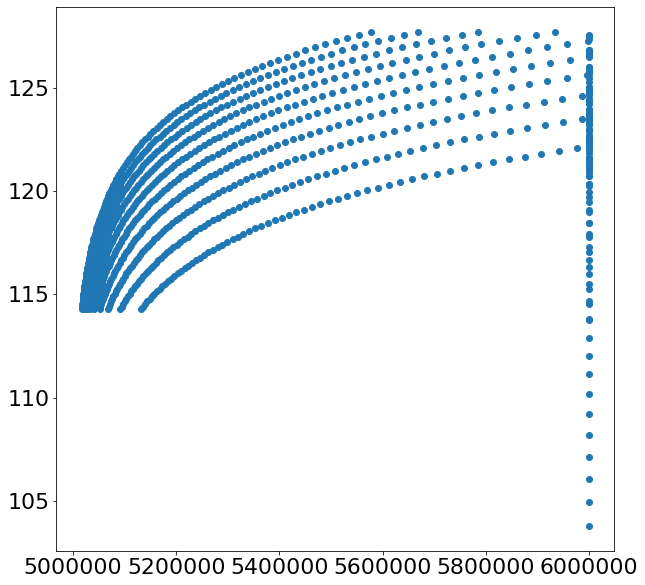

In [0]:
plt.scatter(max_weights, max_partial_pressures)
print()

In [0]:
print(max_p)
print(max_t)
print(w_max)

2.3999999999999995
573.15
5785600.0


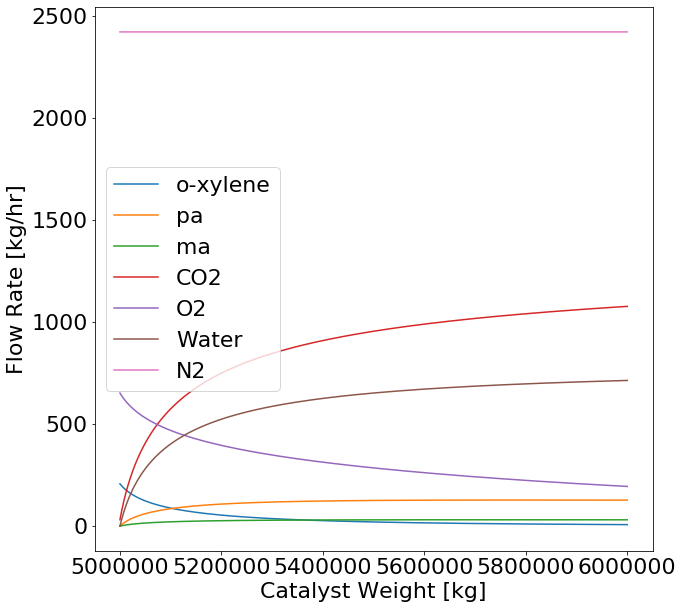

In [0]:
PRESSURE = max_p
K = rate_constants(max_t)

#Get Initial Flow Rates
init = np.zeros(7, dtype=float)
init[0] = x_ox*f0
init[1] = x_pa*f0
init[2] = x_ma*f0
init[3] = x_co2*f0
init[4] = x_o2*f0
init[5] = x_h2o*f0
init[6] = x_N2*f0

sol = odeint(dFdW, init, catalyst_weights)

plt.plot(catalyst_weights, sol[:,0], label = 'o-xylene')
plt.plot(catalyst_weights, sol[:,1], label = 'pa')
plt.plot(catalyst_weights, sol[:,2], label = 'ma')
plt.plot(catalyst_weights, sol[:,3], label = 'CO2')
plt.plot(catalyst_weights, sol[:,4], label = 'O2')
plt.plot(catalyst_weights, sol[:,5], label = 'Water')
plt.plot(catalyst_weights, sol[:,6], label = 'N2')

plt.xlabel('Catalyst Weight [kg]')
plt.ylabel('Flow Rate [kg/hr]')
plt.legend()

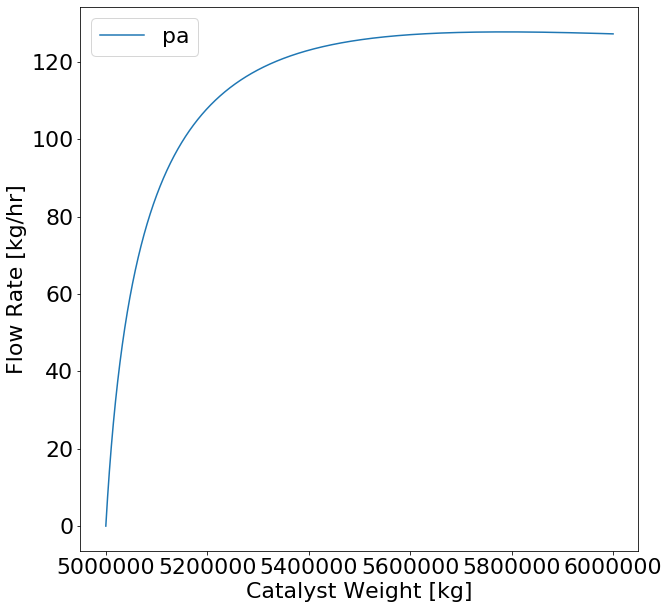

In [0]:
plt.plot(catalyst_weights, sol[:,1], label = 'pa')
plt.xlabel('Catalyst Weight [kg]')
plt.ylabel('Flow Rate [kg/hr]')
plt.legend()